In [376]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro


# Practical exercises with VI

1- Start from the example seen the last week in class. Extend it to estimate a posterior distribution for the variance

2- Consider the following linear regression problem. Find the posterior distribution for the regression parameters

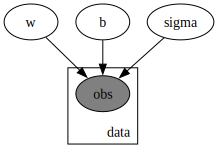

In [377]:
# Generate some synthetic data
N = 100
x = torch.randn(N, 1)
w_true = 2.0
b_true = 1.0
noise_std = 0.5
y = w_true * x + b_true + noise_std * torch.randn(N, 1)

# Define the model
def model(x, y):
    # Priors over weights and bias
    w = pyro.sample("w", dist.Normal(0., 10.))
    b = pyro.sample("b", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    
    # Likelihood
    with pyro.plate("data", len(x)):
        y_pred = w * x + b 
        pyro.sample("obs", dist.Normal(y_pred, sigma).to_event(1), obs=y)



pyro.render_model(model, model_args=(x,y))

In [378]:
# Define the guide (variational distribution)
def guide(x, y):
    # Variational parameters
    w_loc = pyro.param("w_loc", torch.tensor(0.0))
    w_scale = pyro.param("w_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    b_loc = pyro.param("b_loc", torch.tensor(0.0))
    b_scale = pyro.param("b_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(0.))

    # Variational distribution
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    b = pyro.sample("b", dist.Normal(b_loc, b_scale))
    sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))

In [379]:
# Setup SVI
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

# Training loop
num_iterations = 1000
for i in range(num_iterations):
    loss = svi.step(x, y)
    if i % 100 == 0:
        print(f"Iteration {i}, loss: {loss}")

Iteration 0, loss: 95.46991717815399
Iteration 100, loss: 96.24851727485657
Iteration 200, loss: 95.84682106971741
Iteration 300, loss: 95.7925078868866
Iteration 400, loss: 95.6923246383667
Iteration 500, loss: 95.85800290107727
Iteration 600, loss: 96.65335845947266
Iteration 700, loss: 96.43733429908752
Iteration 800, loss: 95.51893377304077
Iteration 900, loss: 95.4558299779892


In [350]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoDiagonalNormal.loc [-2.275051   -1.8208005  -0.19292618  0.34910747  9.18804   ]
AutoDiagonalNormal.scale [0.05301615 0.12441055 0.03892924 0.07753219 0.0696265 ]
w_loc 2.03747
w_scale 0.050263282
b_loc 1.0366979
b_scale 0.053655725
sigma_loc -0.57916814
sigma_scale 1.0637704
tilde_alpha [1.8408105]
tilde_beta [0.38192275]
sigma_inf 0.0
sigma_sup 15.000001
